# 0.0 Imports

In [1]:
import inflection
import datetime
import math
from tabulate              import tabulate

import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import xgboost             as xgb
import random
import warnings
import pickle
import json
warnings.filterwarnings('ignore')

from boruta                import BorutaPy
from matplotlib            import gridspec
from IPython.display       import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from scipy                 import stats
from flask                 import Flask, request, Response

In [2]:
glossary_df = [['Colunas', 'Significado'],
              ['ID', 'An ID that represents a (Store, Data) duple within the test set'],
              ['STORE', 'A unique ID for each store'],
              ['CUSTOMERS', 'The number of customers on a given day'],
              ['OPEN', 'An indicator for whether the store was open: 0 = closed, 1 = open'],
              ['STATEHOLIDAY', 'Indicates a state holiday. Normally all stores, with few exceptions, are closed on state \nholiday. Note that all schools are closed on public holidays and weekends, \na = public holiday, b = Easte Holiday, c = Christmas, 0 = None'],
              ['SCHOOLHOLIDAY', 'Indicates if the (Store,Date) was affected by the closure of public schools'],
              ['STORETYPE', 'Differentiates berween 4 different sore models: a, b, c, d'],
              ['ASSORTMENT', 'Descibes an assortment level: a = basic, b = extra, c= extended'],
              ['COMPETITIONDISTANCE', 'Distance in meters to the nearest competitor store'],
              ['COMPETITIONOPENSINCE[MONTH/YEAR]', 'Gives the approximate year and month of the time the nearest competitior was opened'],
              ['PROMO', 'Indicates whether a store is running a promo on that day'],
              ['PROMO2', 'Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not \nparticipating, 1 = store is participating'],
              ['PROMO2SINCE[YEAR/WEEK]', 'Describes the year and calendar week when the store started participating in Promo2'],
              ['PROMOINTERVAL', 'Describes the consecutive intervals Promo2 is started, naming the months the promotion is \nstart anew, "Feb, May, Aug, Nov" means each round starts in February, May, August, November \nof any given year for that store']
              ]

## 0.1 Helper Functions

In [3]:
def glossary(infos):
    '''Exibe o dicionario do dataframe'''
    print(tabulate(infos, headers = 'firstrow', stralign = 'left', tablefmt = 'simple'))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def ml_error(model_name, y, yhat):
    '''Adiciona o nome do modelo, determina a variável resposta, e a variável predita, realiza os calculos e retorna
    um DataFrame'''
    
    mae = mean_absolute_error(y, yhat )
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat) )
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

def cramer_v(x, y ):
    '''Aplica as correlações para variáveis categorias do conjunto de dados'''
    cm = pd.crosstab(x, y).values # Tabela de contigencia / confusion matrix
    n = cm.sum()
    r, k = cm.shape
    
    # Exibe o resultado do chi2, como ele exibe uma lista, o parametro [0] seleciona o primeiro elemento
    chi2 = stats.chi2_contingency( cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1)/(n-1))
    
    # Corrigindo o viés
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2 / n) / (min(kcorr-1, rcorr-1 )))

def cross_validation(x_training, kfold, model_name, model, verbose = False):
    ''' Aplica Cross-Validation para treinamento e calculo de performance dos modelos'''
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold + 1 )):
        if verbose:
            print(f'\nKFold Number: {k}')
         
        # start and end date for validation
        # start date sempre 6 semanas antes da data final, fold
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k * 6 * 7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1) * 6 * 7)
        
        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset 
        # training
        xtraining = training.drop(['date', 'sales'], axis = 1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1 )
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # Prediction
        yhat = m.predict(xvalidation)
        
        # Performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store perfomance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame(
        {'Model Name': model_name,
         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
         }, index = [0])

def draw_histograms(df, variables, n_rows, n_cols):
    '''Auxilia na plotagem de vários Histogramas de um mesmo dataframe'''
    fig = plt.figure( figsize=(18,8))
    
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot( n_rows, n_cols, i+1)
        df[var_name].hist(bins = 35, ax = ax)
        ax.set_title(var_name)
        
    fig.tight_layout()  # Melhora a aparencia de plotagem do gráfico
    plt.show()

## 0.2 Loading Data

In [4]:
# Le o arquivo de uma vez, default True, le o arquivo em chunks
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory = False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory = False)

# Merge Dataframes
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0 PASSO 01 - Descrição dos dados

In [39]:
# Toda mudança de seção, realizar uma cópia do dataframe
df1 = df_raw.copy()

## 1.1 Rename Columns

In [40]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [41]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Colocar os nomes todos em minusculo e underscore
snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old ))

# Rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions 

In [42]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types 

In [43]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [44]:
# Transformação da coluna date
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA 

In [45]:
df1.isna().sum() / df1.shape[0]

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

In [46]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
874125,751,4,2013-05-09,0,0,0,0,a,0,a,a,650.0,10.0,2006.0,0,NaN,NaN,NaN
840189,265,6,2013-06-08,2438,287,1,0,0,0,a,a,4580.0,NaN,NaN,1,14.0,2015.0,"Jan,Apr,Jul,Oct"
191202,538,2,2015-02-10,3595,583,1,0,0,0,a,a,990.0,2.0,2010.0,0,NaN,NaN,NaN
961763,304,2,2013-02-19,7063,1045,1,1,0,0,a,a,1950.0,7.0,2015.0,0,NaN,NaN,NaN
411121,472,6,2014-06-28,4555,597,1,0,0,0,c,c,5030.0,8.0,2011.0,0,NaN,NaN,NaN


## 1.5 Fillout NA 

In [47]:
# Consultar funcao criada para descricao do dicionario, glossary(glossary_df) 
# competition_distance (compeditor mais proximo)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x )

# competition_open_since_month (mes e ano que o competidor abriu uma 'loja')
# se eu tenho a informacao dos metros em competitor_distacen, fica ilogico eu nao tem a informacao do mes ou ano de que
# o competidor abriu a loja
# Motivos de NA, pode nao existem competidor perto
# Pode nao ter sido anotado, a data de abertura do competidor
# Ou quando a loja da Rossman foi aberta, ja existia um competidor
# O tempo que eu tenho competidor mais proximo pode influenciar no motivo de aumento ou diminuicao de vendas
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                                         else x['competition_open_since_month'], axis = 1)

# competition_open_since_year
# Nos da a informacao do mes ou ano que o competidor mais proximo, abriu loja
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                       else x['competition_open_since_year'], axis = 1)

# Promo2 é uma consecutiva e continua informação se a loja esta em uma promoção

# promo2_since_week
# Descreve o ano e semana quando a loja comecou a partipar da Promo2
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                    else x['promo2_since_week'], axis = 1 )
# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                    else x['promo2_since_year'], axis = 1 )

# promo_interval
# Descreve o intervalo consecutivo que a Promo 2 foi iniciada, nomeando os meses que ela comecou outra vez, por exemplo
# Feb, May, Aug, Nov, significa que cada nova promocao comecou nesses meses
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct',11: 'Nov',12: 'Dec'}

# Preenchi os valores NaN por 0
df1['promo_interval'].fillna(0, inplace = True)

# Peguei as datas de vendas daquela loja e coloquei em uma coluna com o nome do respectivo mes
df1['month_map'] = df1['date'].dt.month.map(month_map)


# Se o mes contido na coluna month_map esta na coluna promo_interval, significa que estava em promocao, entao
# 0 sera para lojas que nao aderiram a promocao consecutiva ou continua e 1 sera para as quais aderiram
# Esse procedimento foi realizado, pois no desenvolvimento de modelos de ML, vemos como interessante saber se a 
# loja, estava ou nao em promocao, apesar de termos a informacao dos meses que a loja estava em promocao, e necessario
# transformar essa informacao de string para numerica
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split( ',' )
                                                             else 0, axis = 1 )

## 1.6 Change Types 

In [48]:
# As informacoes das datas estavam em decimais
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical 

In [49]:
num_attributes = df1.select_dtypes ( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes 

In [50]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [51]:
# Recuperando os valores únicos de cada categoria
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

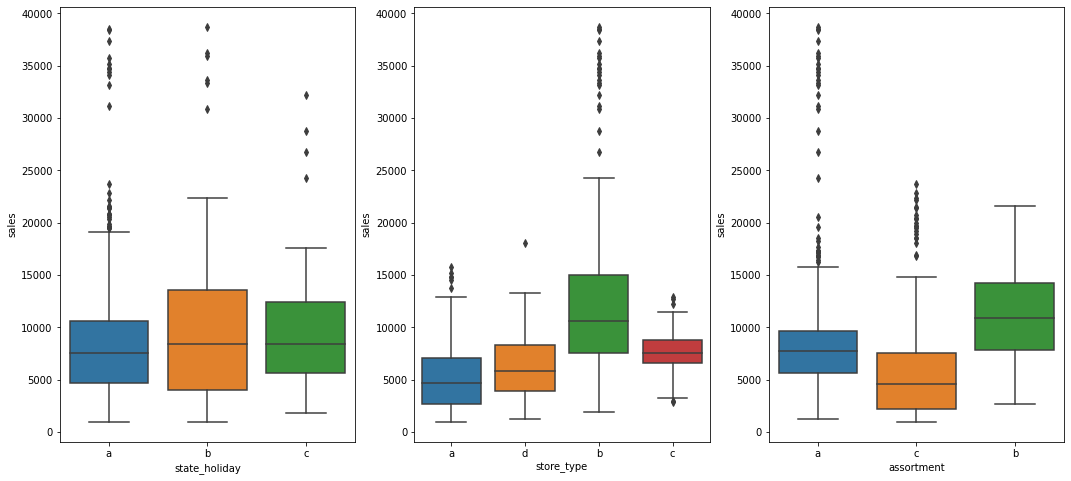

In [52]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

plt.figure(figsize = (18,8))

plt.subplot(1, 3, 1 )
sns.boxplot(x='state_holiday', y = 'sales', data = aux1 )

plt.subplot(1, 3, 2 )
sns.boxplot(x='store_type', y = 'sales', data = aux1 )

plt.subplot(1, 3, 3 )
sns.boxplot(x='assortment', y = 'sales', data = aux1 );

# 2.0. PASSO 02 - Feature Engineering

In [53]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

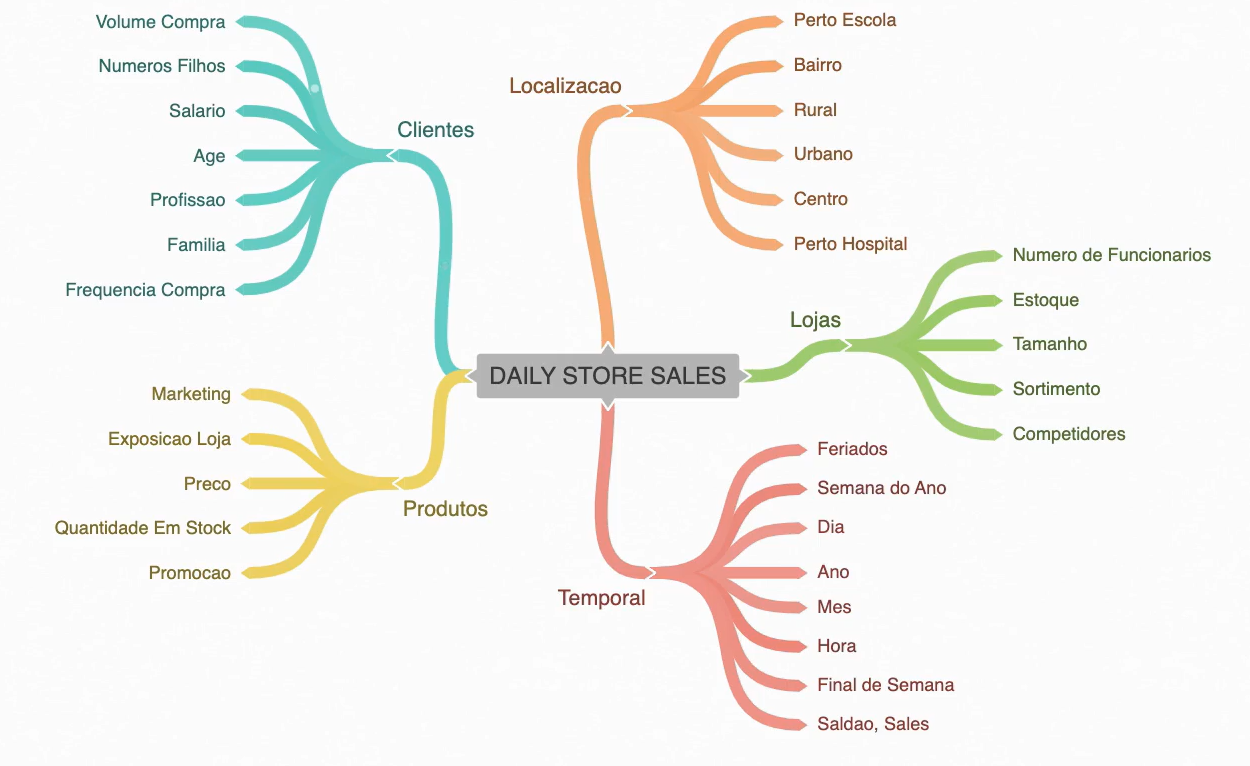

In [54]:
Image('img/MapaHipoteses.png')

### 2.1.a Criação de Hipóteses

#### 2.1.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mas tempo deveriam vender mais

#### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.1.3 Hipóteses Temporais

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre dos anos.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais. 

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre dos anos.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [55]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
# adicionado da1 = 1, pois nas colunas manipuladas, não temos o dia então generalizamos
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'],
                                                                  month = x['competition_open_since_month'], day = 1),
                                                                  axis = 1 )

# O tempo que a competição começou em meses
df2['competition_time_month'] = (( df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(
                              lambda x:datetime.datetime.strptime ( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7 ))

# Resultada da diferença em semanas
# A promocao comecou, antes ou depois da ultima venda?
# valores positivos, ela estava ou esta em promocao
# valores negativos, ela entrou em promocao depois da data da ultima venda
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) / 7 ).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                             else 'easter_holiday' if x == 'b'
                                                             else 'christmas' if x == 'c' else 'regular_day')

# 3.0. PASSO 03 - Filtragem das variáveis

In [56]:
df3 = df2.copy()

In [57]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### 3.1. Filtragem de linhas

In [58]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

In [59]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### 3.2. Seleção das colunas

In [60]:
# Customers, não temos o número de customers para o momento daqui 6 meses, o que não é a proposta do projeto
# Open, não nos fornece muitas informações, já que 0 e fechado e 1 e simsplismente loja aberta
# Promo_interval, geramos variáveis dela, ou seja, outras colunas, dessa maneira, podemos descarta-la
# Month_map, geramos variáveis dela, ou seja, outras colunas, dessa maneira, podemos descarta-la
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0. PASSO 04 - Análise Exploratória dos Dados (EDA)

In [61]:
df4 = df3.copy()

### 4.1. Análise Univariada

#### 4.1.1 Response Variable

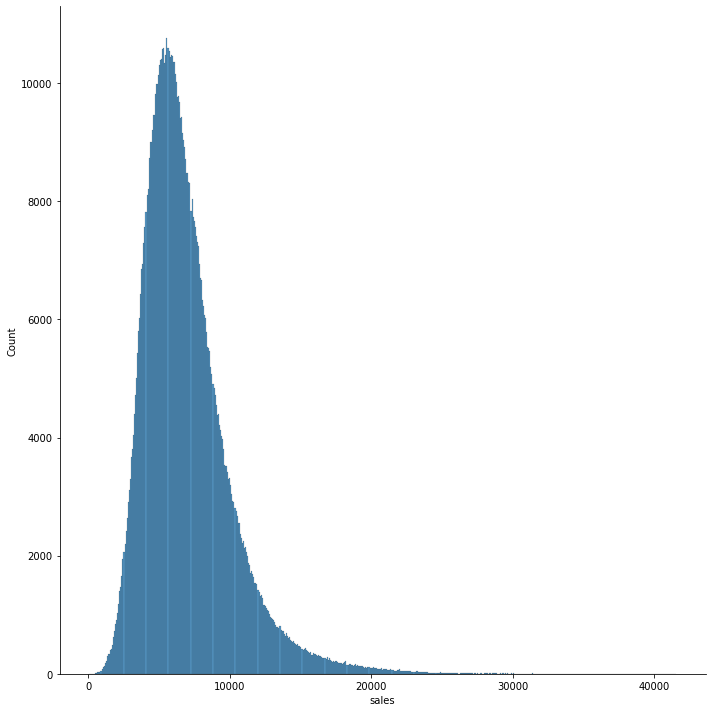

In [62]:
sns.displot(df4['sales'], height = 10, aspect = 1);

#### 4.1.2 Numeric Variable

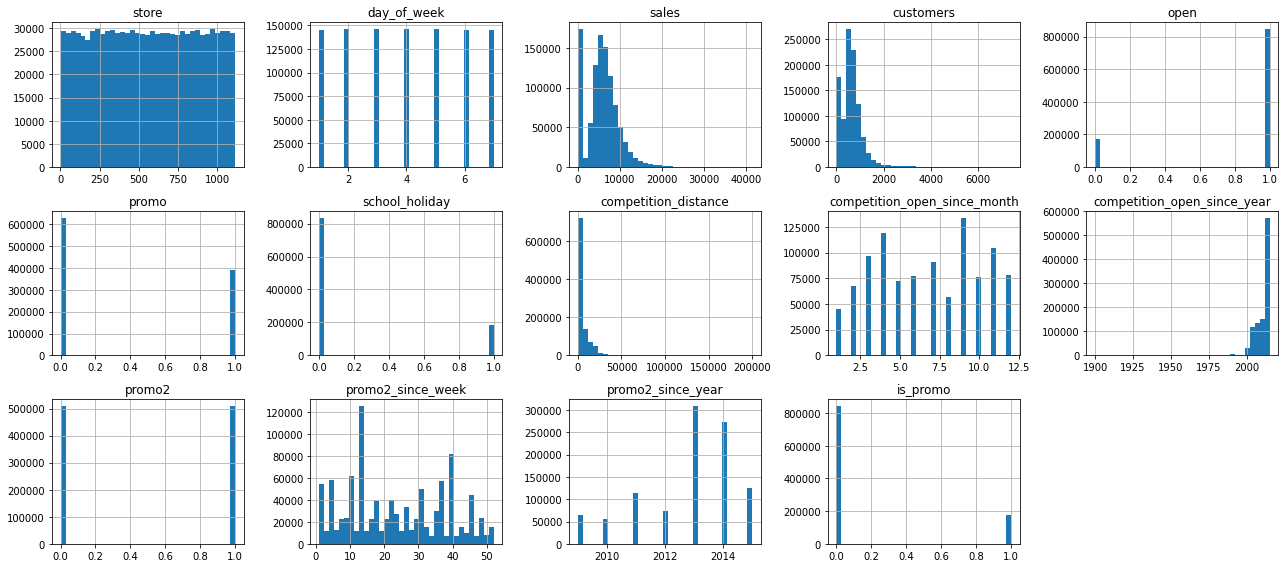

In [63]:
draw_histograms(num_attributes, num_attributes.columns, 3, 5)

#### 4.1.3 Categorical Variable

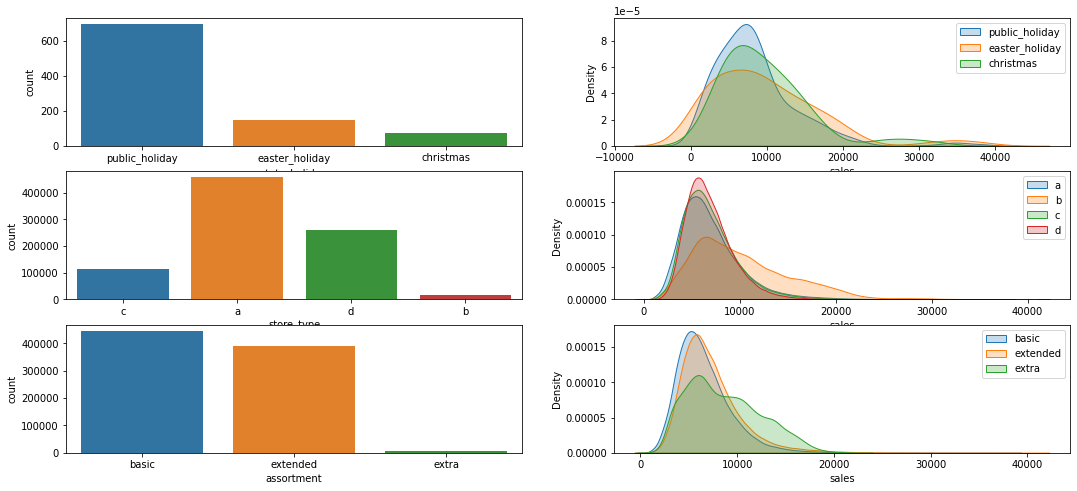

In [64]:
# State_holiday
plt.figure(figsize = (18,8))
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3, 2, 2)
# Parâmetro shade, faz com que os gráficos fiquem sobrepostos
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)
plt.legend()

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)
plt.legend()

#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)
plt.legend();

### 4.2. Análise Bivariada

#### H1. Lojas com maior sortimentos deveriam vender mais
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

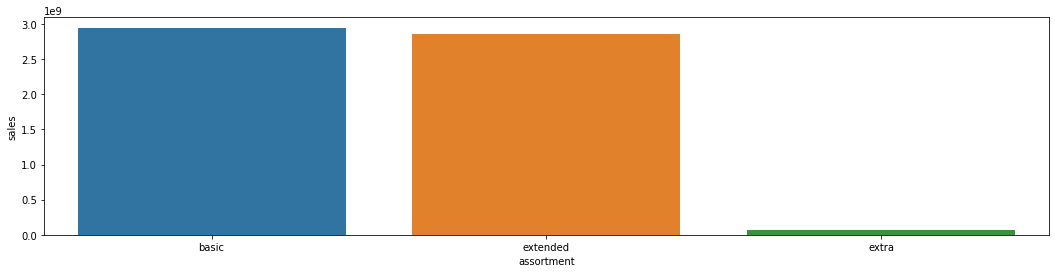

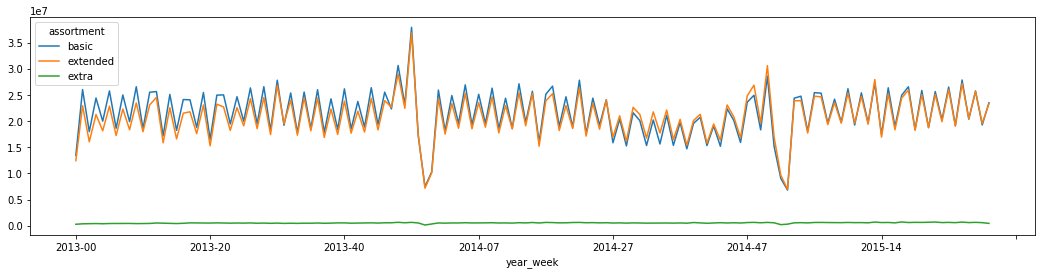

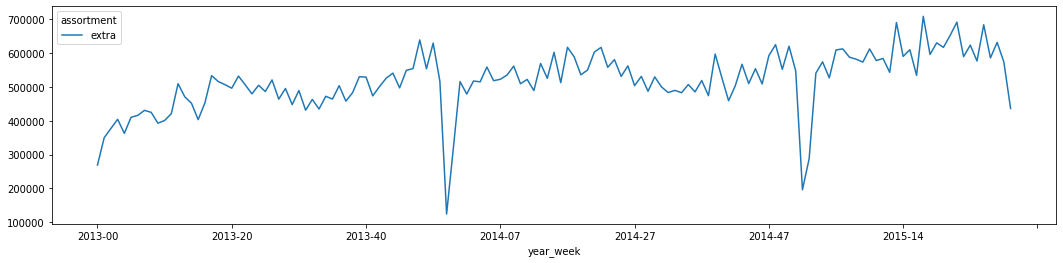

In [65]:
plt.figure(figsize = (18,4))
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x = 'assortment', y = 'sales', data = aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

# Devido ao aux2, exibir o mesmo dia repetido, para cada registro, seria interessante manter somente um dia com varios
# registros ao longo das colunas, dessa maneira podemos pivotar o dataframe com o codigo abaixo
aux2.pivot( index = 'year_week' , columns = 'assortment' , values = 'sales' ).plot(figsize=(18,4))

# Observando em detalhe a categoria 'extra'
aux3 = aux2[aux2['assortment'] == 'extra' ]
aux3.pivot( index = 'year_week' , columns = 'assortment' , values = 'sales' ).plot(figsize=(18,4));

#### H2. Lojas com competidores mais próximos deveriam vender mais
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS

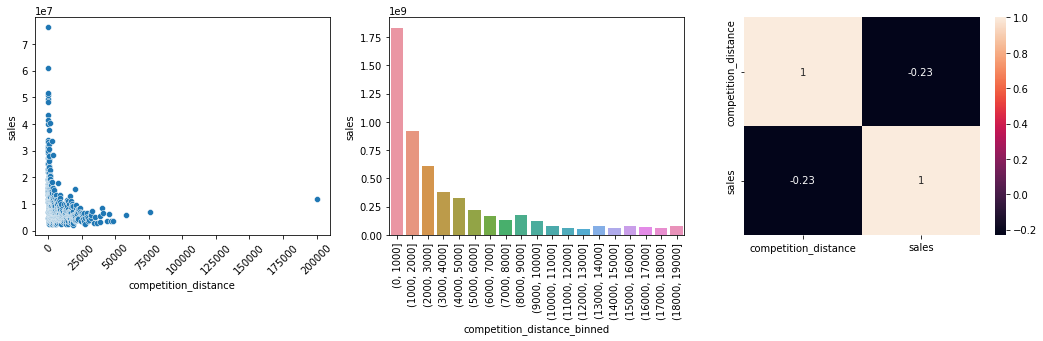

In [66]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize = (18,4))

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)
plt.xticks(rotation = 45 )

# Criando os grupos de sepacoes que sera utilizado nos bins
plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000 ))

# Determinando em qual grupo de bins a informacao ira se encaixar
# () significa conjunto aberto, ou seja, não incluí o intervalo
# [] significa que incluí o intervalo
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins )

# Somando as vendas dentro dos grupos
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2 );
plt.xticks(rotation = 90);

# Annot = True, ou anotação, significa que queremos ver os valores, ou seja, o rótulo dos dados 
plt.subplot(1, 3, 3 )
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H3. Lojas com competidores a mais tempo deveriam vender mais
**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

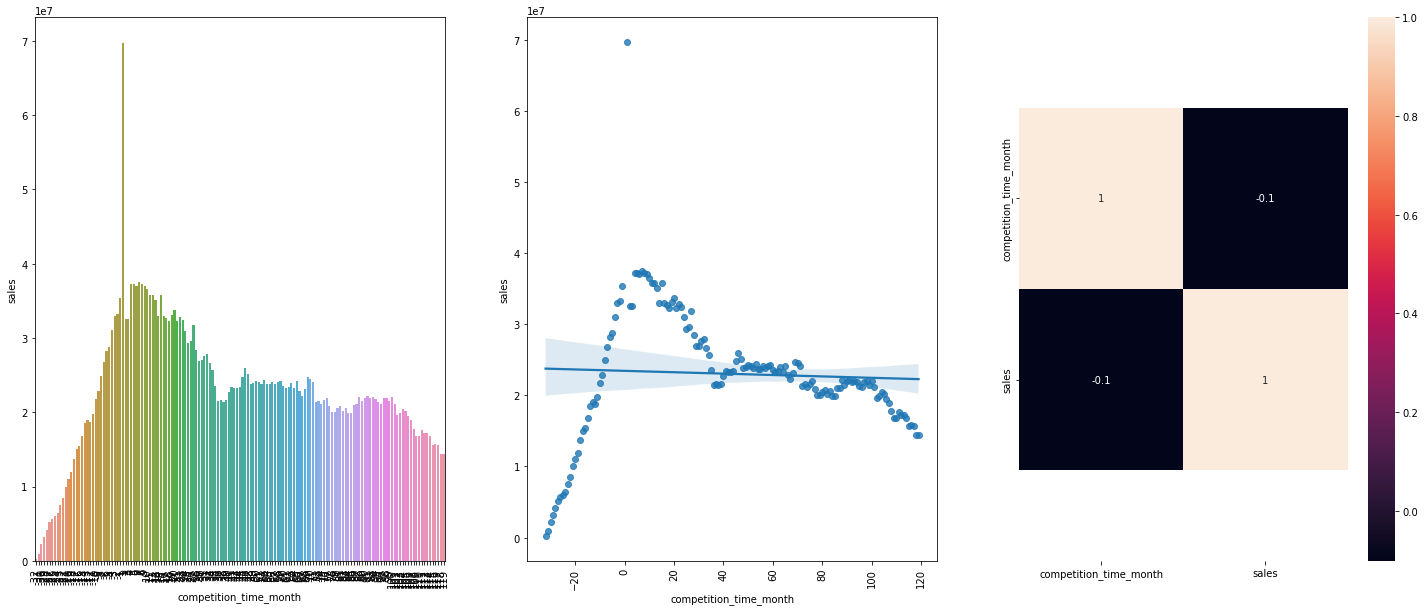

In [67]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# Somente os 120 primeiros meses de competição
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks(rotation = 90 );

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90 )

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);
bottom, top = x.get_ylim()
x.set_ylim( bottom + 0.5, top - 0.5);

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

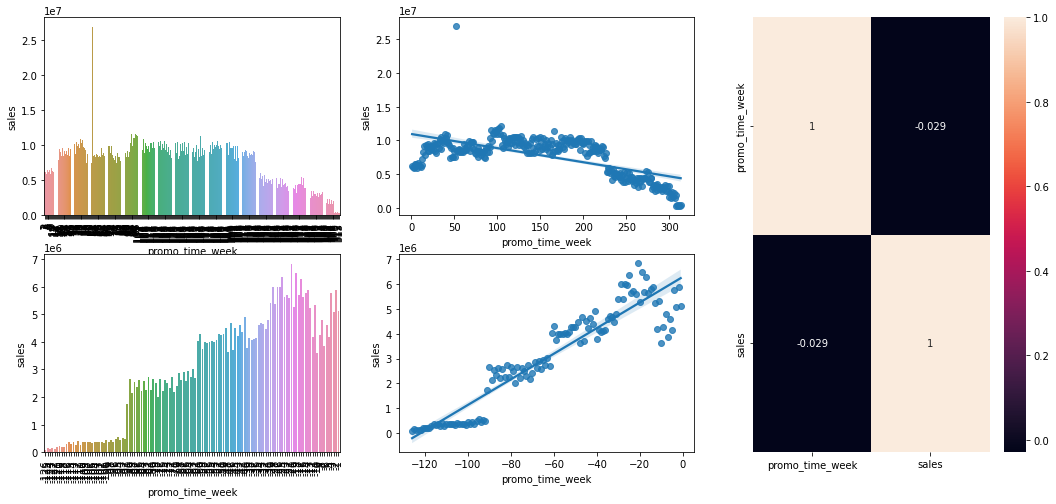

In [68]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec( 2, 3 )

plt.figure(figsize = (18,8))

plt.subplot(grid[0,0])
# A promocao comecou, antes ou depois da ultima venda?
# valores positivos, ela estava ou esta em promocao
# valores negativos, ela entrou em promocao depois da data da ultima venda
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2 );
plt.xticks(rotation = 90 );

plt.subplot(grid[0, 1])
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2 );

plt.subplot(grid[1, 0 ])
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90 );

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:, 2 ])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### <s>H5. Lojas com mais dias de promoção deveriam vender mais</s>

In [69]:
# Essa hipótese foi inicialmente descartada, pois foi entendido que tem relação com a hipótese H4, poderá ser feito uma nova
# feature para cálculo dessa hipótese no próximo ciclo do CRISP.

#### H6. Lojas com mais promoções consecutivas deveriam vender mais
**FALSA** Lojas com mais promocoes consecutivas vendem menos

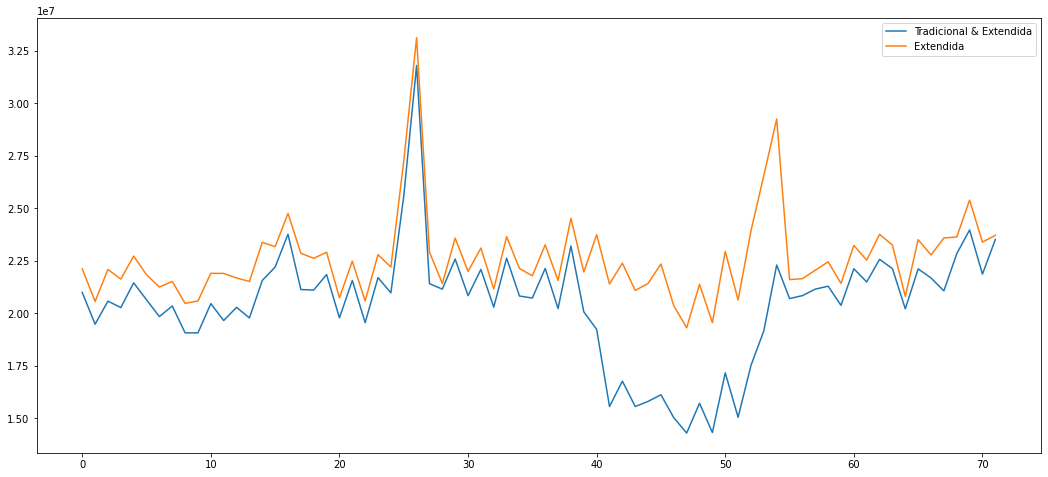

In [70]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()

ax = aux1.plot(figsize=(18,8))

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax )

ax.legend(labels = ['Tradicional & Extendida', 'Extendida'])
plt.show();

#### H7. Lojas abertas durante o feriado de Natal deveriam vendem mais.
**FALSA** Lojas com vendas durante o feriado de natal vendem menos.

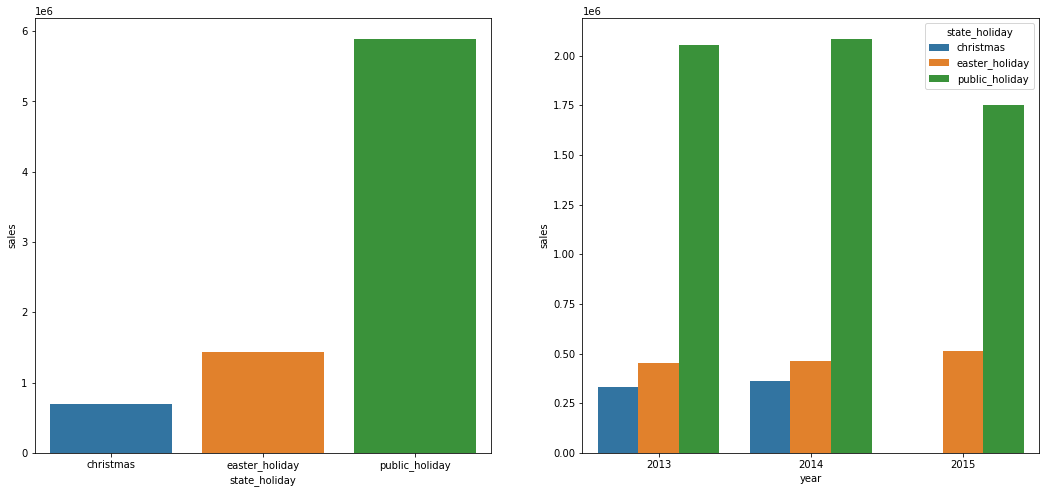

In [71]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize = (18,8))

# Por feriado
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1 );

# Por ano e feriado
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y = 'sales', hue = 'state_holiday', data = aux2 );

#### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Apesar de não termos o ano de 2015 fechado, vemos uma tendência das lojas venderem menos ao longo dos anos

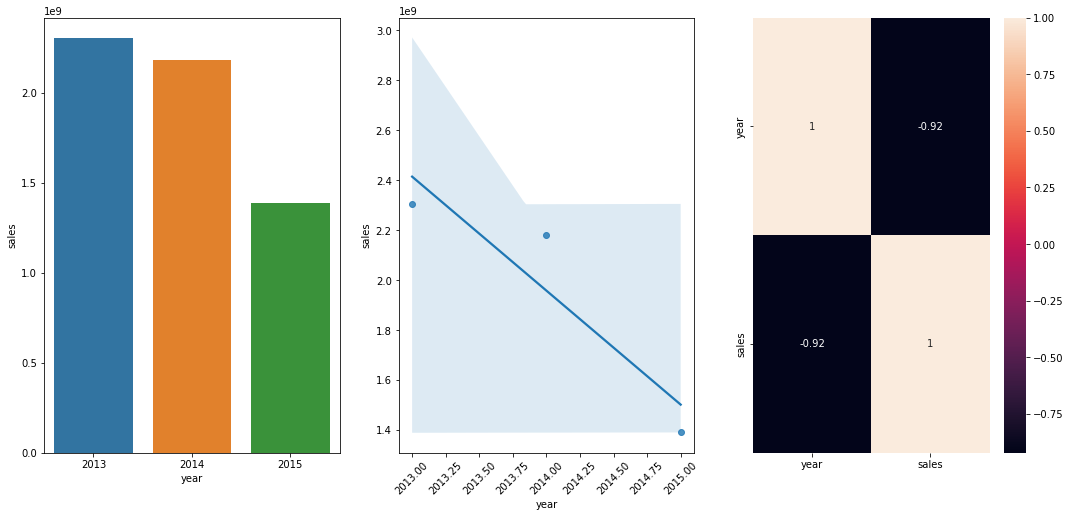

In [72]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize = (18,8))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data = aux1 );

plt.subplot(1,3,2)
sns.regplot(x = 'year', y='sales', data = aux1 );
plt.xticks( rotation = 45 )

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True );

#### H9. Lojas deveriam vender mais no segundo semestre dos anos.
**FALSA** Lojas vendem menos ao longo do segundo semestre dos anos

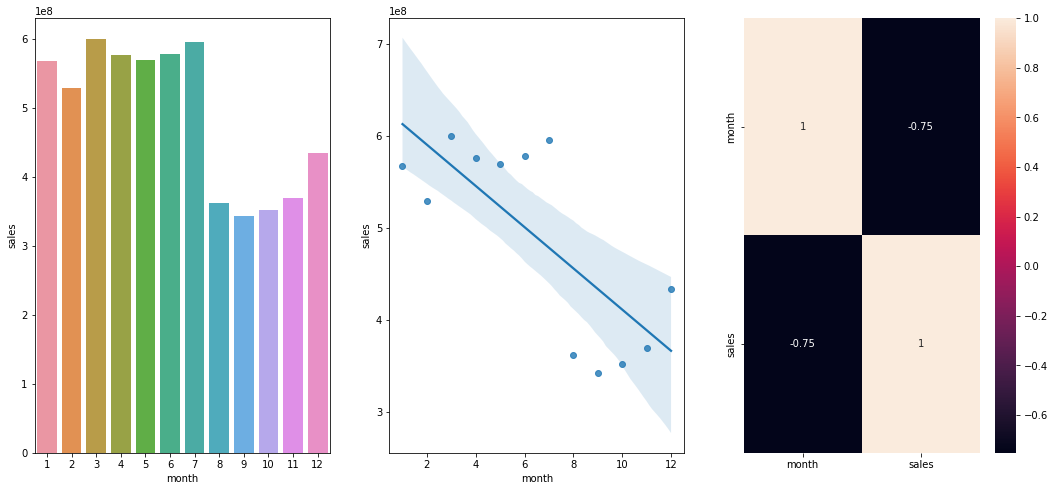

In [73]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize = (18,8))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data = aux1 );

plt.subplot(1,3,2)
sns.regplot(x = 'month', y='sales', data = aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True );

#### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

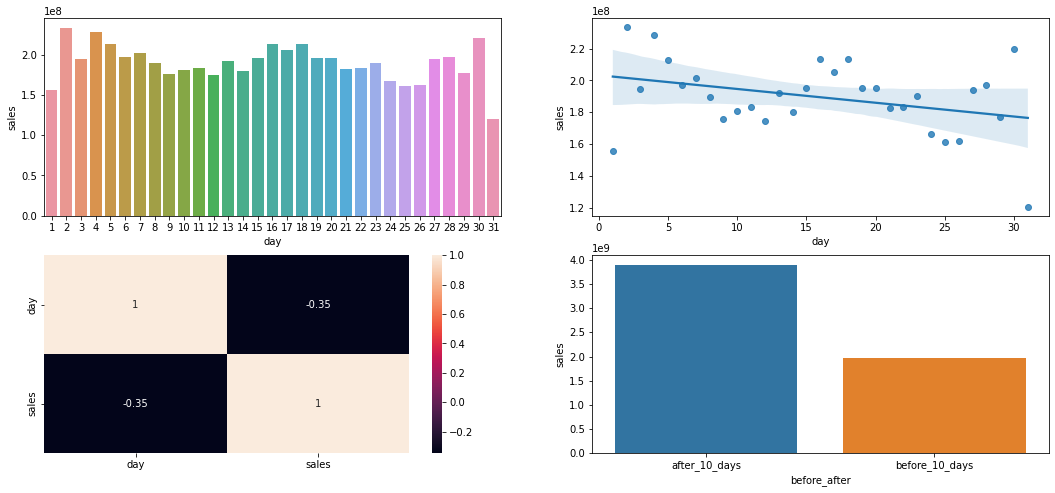

In [74]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize = (18,8))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data = aux1 );

plt.subplot(2,2,2)
sns.regplot(x = 'day', y='sales', data = aux1 );

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True );

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

#### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos no finais de semana

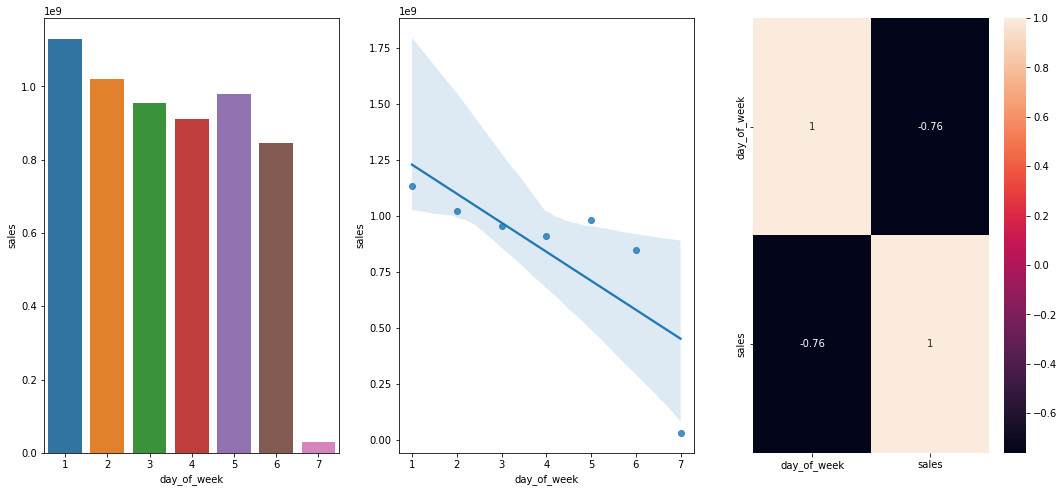

In [75]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize = (18,8))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data = aux1 );

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y='sales', data = aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True );

#### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

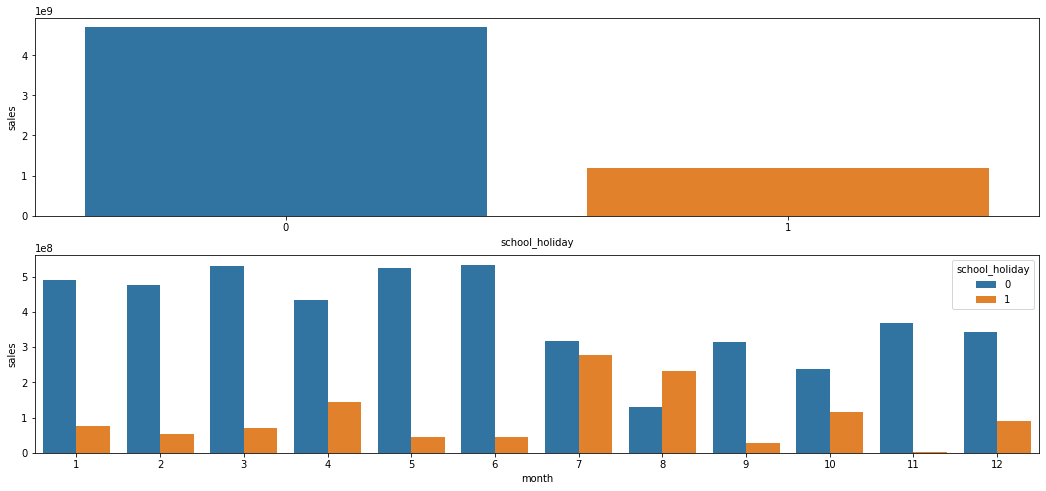

In [76]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize = (18,8))

plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2 );

#### 4.2.1. Resumo das Hipóteses

In [77]:
tab =  [['Hipoteses','Conclusao', 'Relevancia'],
       ['H1','Falsa','Baixa'],
       ['H2','Falsa','Media'],
       ['H3','Falsa','Media'],
       ['H4','Falsa','Baixa'],
       ['H5','-----','-----'],
       ['H6','Falsa','Baixa'],
       ['H7','Falsa','Media'],
       ['H8','Falsa','Alta'],
       ['H9','Falsa','Alta'],
       ['H10','Verdadeira','Alta'],
       ['H11','Verdadeira','Alta'],
       ['H12','Verdadeira','Baixa'],]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -----        -----
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


### 4.3. Análise Multivariada

#### 4.3.1 Numerical Attributes

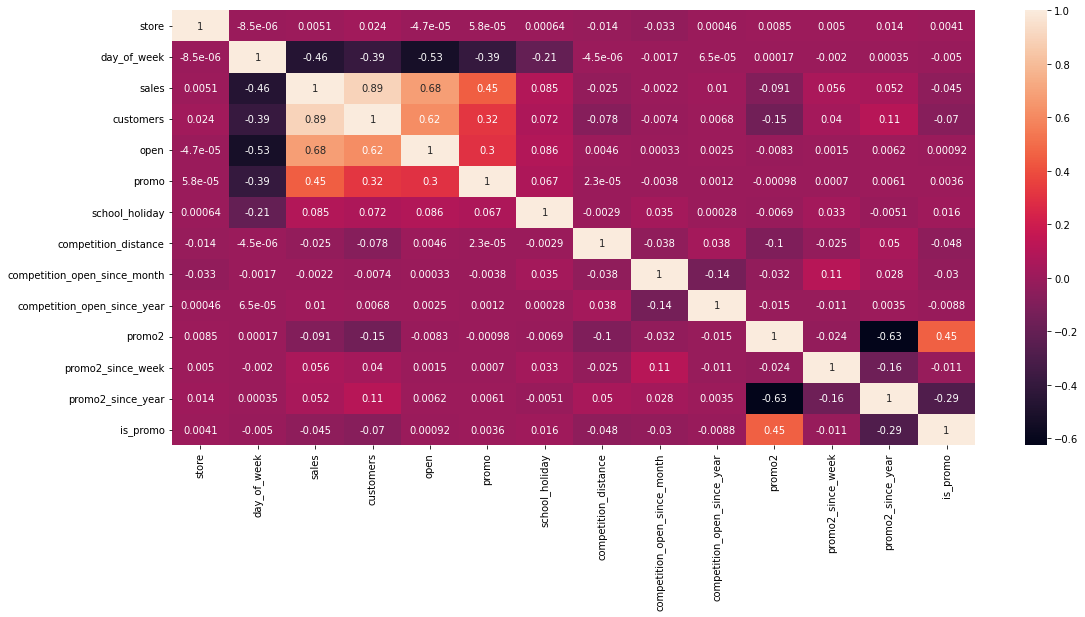

In [78]:
correlation = num_attributes.corr( method = 'pearson')
plt.figure(figsize = (18,8))
sns.heatmap(correlation, annot = True );

#### 4.3.2 Categorical Attributes

In [79]:
# Only calculated data
a = df4.select_dtypes(include = 'object')

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9]} )

#Final Dataset
# Nomes das linhas iguais aos das colunas
d = d.set_index(d.columns)

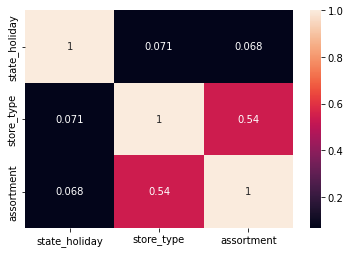

In [80]:
sns.heatmap(d, annot = True);

# 5.0. PASSO 05 - Data Preparation

In [81]:
df5 = df4.copy()

### 5.1. Normalização

 - Não foram realizadas normalizações, pois em nosso conjunto de dados, conforme análise 4.1.2, não temos distribuições normais

### 5.2. Rescaling 

In [82]:
# Identificando as variáveis para aplicação de rescaling
a = df5.select_dtypes(include = ['int64', 'float64'])

a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [83]:
# Utilizado o boxplot para identificação de outliers, para seguir com a escolha de Robust ou MinMax Scaler
# sns.boxplot(df5['competition_distance']);
# sns.boxplot(df5['competition_time_month']);
# sns.boxplot(df5['promo_time_week']);

In [84]:
rs = RobustScaler()
mms = MinMaxScaler()
path = '/home/guilinux/repos/Comunidade-DS/02.ds_em_producao/parameter/' 

# competiton distance
# Devido a apresentacao de outliers, sera utilizada RobustScaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )

# Salvando as transformaçães em pickle, para aplicação em dados novos
pickle.dump( rs, open( path + 'competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump( rs, open( path + 'competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values )
pickle.dump( mms, open( path + 'promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values )
pickle.dump( mms, open( path + 'year_scaler.pkl', 'wb'))

### 5.3. Transformação

#### 5.3.1 Encoding

In [51]:
# state_holiday - One-Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open(path + 'store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2 Response Variable Transformation

In [52]:
# Log Transformation
df5['sales'] = np.log1p(df5['sales'])

# sns.displot(df5['sales']);

#### 5.3.3 Nature Transformation

In [53]:
# day of week - Atencao para ajustar o periodo max, por exemplo dias 7, mes 30, ... ciclos !
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7 ) ) )

# month
# Divido pelo número do ciclo, para mês, 12
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# day
# Divido pelo número do ciclo, para o dia, 30
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# week of year
# Divido pelo número do ciclo, para a semana do ano, 52
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52 ) ) )

# 6.0. PASSO 06 - Feature Selection

In [54]:
df6 = df5.copy()

### 6.1. Split dataframe into training and test dataset

In [55]:
# Deletando as várias que derivamos outras ... Passo 5.3.3 Nature Transformation e Feature Engineering
# Fazemos isso, pois as colunas abaixo foram variadas de outras features, ou seja, a feature original já não é mais necessária
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [56]:
# Encontrando a data anterior a 6 semanas, com referencia o último registro de data, do dataset
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days =  6 * 7)

Timestamp('2015-06-19 00:00:00')

In [57]:
# training dataset
# As últimas 6 semanas será utilizadas para teste, anterior essa data, foram utilizado para dados de treinamento
X_train = df6[df6['date'] < '2015-06-19']

# Variavel resposta do treino
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']

# Variavel resposta do teste
y_test = X_test['sales']

print(f'Training Min Date: {X_train["date"].min()}')
print(f'Training Max Date: {X_train["date"].max()}')

print(f'\nTest Min Date: {X_test["date"].min()}')
print(f'Test Max Date: {X_test["date"].max()}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.2. Boruta as Feature Selector

In [58]:
# # training and test dataset for Boruta
# # Devera ser passado um vetor de numeros, por isso o .values no final
# # Nao sao utilizados o data e o sales, por que sao dados de treino
# X_train_n = X_train.drop(['date', 'sales'], axis = 1).values

# # ravel(), utilizado para colocar toda a informacao dentro de um vetor
# y_train_n = y_train.values.ravel()
# 
# # Definindo o modelo a ser utilizado, RandomForestRegressor
# rf = RandomForestRegressor( n_jobs = -1 )
# 
# # Define Boruta
# Verbose 2, possibilita enchergamos o que o algoritmo esta realizando
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state=42).fit(X_train_n, y_train_n)

#### 6.2.1. Best Features from Boruta

In [59]:
# # Exibe os valores de Rankeamento do boruta
# cols_selected = boruta.support_.tolist()
# 
# # best features
# # dropando as colunas data e sales, porem sem coloca-las em vetores
# X_train_fs = X_train.drop(['date', 'sales'], axis = 1 )
# cols_selected_boruta = X_train_fs.iloc[ : , cols_selected].columns.to_list()
# 
# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### 6.3. Manual Feature Selection

In [60]:
cols_not_selected_boruta = ['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']


cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# Columns to add
feat_to_add = ['date', 'sales']

# Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - Machine Learning Modelling

In [61]:
# Manipulando as colunas selecionados pelo Boruta
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
# Dataset completo, porem com as features selecionados pelo Boruta
x_training = X_train[cols_selected_boruta_full]

### 7.1. Average Model

In [62]:
# O dataset não tem a coluna de vendas nessa etapa
aux1 = x_test.copy()

# Aqui foi adiciona a coluna 'sales' pois na seleção feita pelo Boruta, não tínhamos essa coluna
aux1['sales'] = y_test.copy()

# Prediction
# Coloque os resultados do groupby dentro de uma variável
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})

# Retornando os valores de média de venda de cada loja, para o dataset original, aux1
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

# Performance
# Foi retornado os valores de sales, para sua original, pois no passo 5.0, fizemos o log da mesma
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


### 7.2. Linear Regression Model 

In [63]:
# model
# Vale ressaltar que os próximos modelos, não tratam as colunas com formato de datas
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.2.1 Linear Regression Model - Cross Validation 

In [64]:
# lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
# lr_result_cv

### 7.3. Linear Regression Regularized Model - Lasso

In [65]:
# model
# Alpha, determinante para fator multiplicador dos pesos, para que fiquem dentro de um range, ou mesma relevancia
lrr = Lasso( alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737


#### 7.3.1 Linear Regression Regularized Model Lasso - Cross Validation

In [66]:
# lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
# lrr_result_cv

### 7.4. Random Forest Regressor

In [67]:
# model
# estimators, quantas arvores serao criadas
# njobs, -1 para ele rodar em paralelo
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


#### 7.4.1 Random Forest Regressor - Cross Validation

In [68]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = False)
# rf_result_cv

### 7.5. XGBoost Regressor

In [69]:
# Model
# Existe também o XGBClassification
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators = 100,
                            eta = 0.01, # quantas passadas serão utilizadas para aprendizado
                            max_depth = 10, # máxima ramificação da arvore
                            subsample = 0.7, # porcentagem das variáveis as quais quero fazer amostragem
                            colsample_bytree = 0.9).fit(x_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.705545,0.949492,7330.988585


#### 7.5.1 XGBoost Regressor - Cross Validation

In [70]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = False)
# xgb_result_cv

### 7.6. Compare Model's Performance

#### 7.6.1 Single Performance

In [71]:
# modelling_result = pd.concat([lr_result, lrr_result, rf_result, xgb_result ])
# modelling_result.sort_values('RMSE')

#### 7.6.2 Real Performance - Cross Validation

In [72]:
# modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ])
# modelling_result_cv.sort_values('RMSE CV')

# 8.0. PASSO 08 - Hyperparameter Fine Tuning

### 8.1. Random Search

In [73]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3,5,9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#}
#
#MAX_EVAL = 10 

In [74]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items() }
#    print(hp)
#    
#    # model
#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                n_estimators = hp['n_estimators'],
#                                eta = hp['eta'],
#                                max_depth = hp['max_depth'],
#                                subsample = hp['subsample'],
#                                colsample_bytree = hp['colsample_bytree'],
#                                min_child_weight = hp['min_child_weight'] )
#    
#    # performance
#    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose = False)
#    final_result = pd.concat([final_result, result])
#    
#final_result

### 8.2. Final Model

In [75]:
# Aqui os parametros foram retirados do vídeo, pois manualmente demoraria muito tempo para ser exibido os resultados
param_tuned = {
    'n_estimators': 3000 ,
    'eta': 0.03,
    'max_depth': 5 ,
    'subsample': 0.7 ,
    'colsample_bytree': 0.7 ,
    'min_child_weight': 3 
}

In [76]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators = param_tuned['n_estimators'],
                            eta = param_tuned['eta'],
                            max_depth = param_tuned['max_depth'],
                            subsample = param_tuned['subsample'],
                            colsample_bytree = param_tuned['colsample_bytree'],
                            min_child_weight = param_tuned['min_child_weight'] ).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,764.975639,0.114861,1100.725149


In [87]:
# Calculando o MPE, modelo SUPER ou SUB-ESTIMANDO
mpe = mean_percentage_error(np.expm1( y_test ), np.expm1( yhat_xgb_tuned ))
mpe

-0.01759492443152097

# 9.0. PASSO 09 - Tradução e Interpretação do ERRO

In [79]:
df9 = X_test[ cols_selected_boruta_full ]

In [80]:
# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,...,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,5263.0,5736.361328
1,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,6064.0,5914.195312
2,3,1,0,1,1.903226,12,2006,1,14,2011,...,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,8314.0,9394.951172
3,4,1,2,3,-0.275806,9,2009,0,31,2015,...,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,13995.0,11596.350586
4,5,1,0,1,4.448387,4,2015,0,31,2015,...,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,4822.0,6324.432129


### 9.1. Business Performance

In [81]:
# Sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE para cada linha
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( 
                lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename( columns = {0: 'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( 
                lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(
                columns = {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on = 'store' )

# Unindo o dataset com as previsoes e os calculos de MAE e MAPE
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Sort columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [82]:
df92.sort_values('MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108359.789062,104977.608630,111741.969495,3382.180433,0.602768
908,909,220300.078125,212395.141071,228205.015179,7904.937054,0.518675
875,876,194060.812500,189924.534732,198197.090268,4136.277768,0.337730
169,170,201541.687500,200194.421637,202888.953363,1347.265863,0.332923
748,749,206800.953125,205789.192013,207812.714237,1011.761112,0.283049


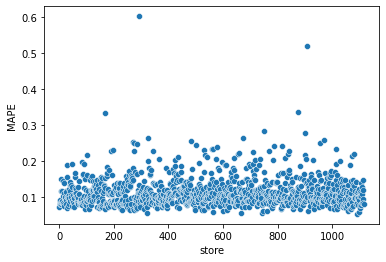

In [83]:
sns.scatterplot(x = 'store', y = 'MAPE', data = df92);

### 9.2. Total Performance


In [84]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0 ).reset_index().rename(
                                                                      columns = {'index': 'Scenarios', 0:'Values'})

# Formatando a saida para R$
df93['Values'] = df93['Values'].map('${:,.2f}'.format )
df93.head()

,Scenarios,Values
0,predictions,"$286,435,616.00"
1,worst_scenario,"$285,579,535.63"
2,best_scenario,"$287,291,675.81"


### 9.3. Machine Learning Performance

In [85]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

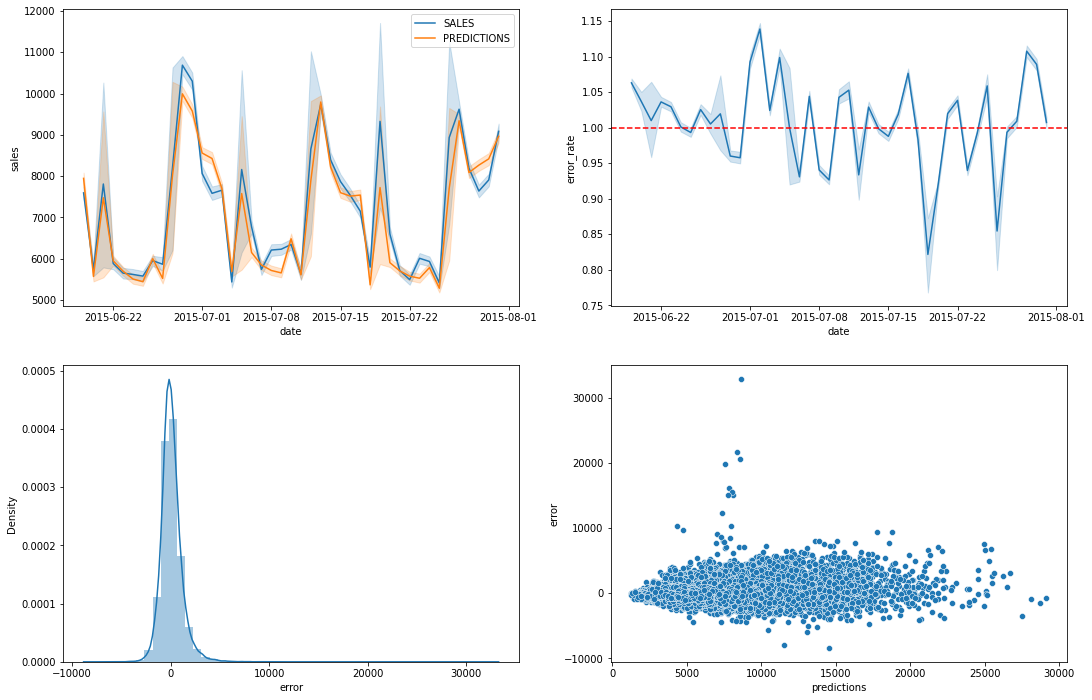

In [86]:
# Comparativo Real das vendas VS previsões
plt.figure(figsize=(18, 12))
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'SALES')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS')

# Identificando sub e superestimação do modelo
plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline(1, linestyle ='--', color = 'red')

# Distribuição do erro
plt.subplot(2,2,3)
sns.distplot(df9['error'])

# Análise de resíduo
plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0. PASSO 10 - Deploy Model to Production

In [78]:
# Salvando o modelo no PICKLE
# pickle.dump(model_xgb_tuned, open('/home/guilinux/repos/Comunidade-DS/02.ds_em_producao/model/model_rossman.pkl', 'wb'))

### 10.1. Rossmann Class

In [3]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__( self ):
        self.path = '/home/guilinux/repos/Comunidade-DS/02.ds_em_producao/parameter/' 
        self.competition_distance_scaler    = pickle.load( open( self.path + 'competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler  = pickle.load( open( self.path + 'competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler         = pickle.load( open( self.path + 'promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                    = pickle.load( open( self.path + 'year_scaler.pkl', 'rb'))
        self.store_type_scaler              = pickle.load( open( self.path + 'store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        
        # 1.1 Rename Columns
        # Foi removido da cols_old, Sales and Customers

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        # Colocar os nomes todos em minusculo e underscore
        snakecase = lambda x: inflection.underscore( x )

        cols_new = list(map(snakecase, cols_old ))

        # Rename
        df1.columns = cols_new

        ## 1.3 Data Types 

        # Transformação da coluna date
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA 

        # Consultar funcao criada para descricao do dicionario, glossary(glossary_df) 
        # competition_distance (compeditor mais proximo)
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x )

        # competition_open_since_month (mes e ano que o competidor abriu uma 'loja')
        # se eu tenho a informacao dos metros em competitor_distacen, fica ilogico eu nao tem a informacao do mes ou ano de que
        # o competidor abriu a loja
        # Motivos de NA, pode nao existem competidor perto
        # Pode nao ter sido anotado, a data de abertura do competidor
        # Ou quando a loja da Rossman foi aberta, ja existia um competidor
        # O tempo que eu tenho competidor mais proximo pode influenciar no motivo de aumento ou diminuicao de vendas
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                                                 else x['competition_open_since_month'], axis = 1)

        # competition_open_since_year
        # Nos da a informacao do mes ou ano que o competidor mais proximo, abriu loja
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                               else x['competition_open_since_year'], axis = 1)

        # Promo2 é uma consecutiva e continua informação se a loja esta em uma promoção

        # promo2_since_week
        # Descreve o ano e semana quando a loja comecou a partipar da Promo2
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                            else x['promo2_since_week'], axis = 1 )
        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                            else x['promo2_since_year'], axis = 1 )

        # promo_interval
        # Descreve o intervalo consecutivo que a Promo 2 foi iniciada, nomeando os meses que ela comecou outra vez, por exemplo
        # Feb, May, Aug, Nov, significa que cada nova promocao comecou nesses meses
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                     7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct',11: 'Nov',12: 'Dec'}

        # Preenchi os valores NaN por 0
        df1['promo_interval'].fillna(0, inplace = True)

        # Peguei as datas de vendas daquela loja e coloquei em uma coluna com o nome do respectivo mes
        df1['month_map'] = df1['date'].dt.month.map(month_map)


        # Se o mes contido na coluna month_map esta na coluna promo_interval, significa que estava em promocao, entao
        # 0 sera para lojas que nao aderiram a promocao consecutiva ou continua e 1 sera para as quais aderiram
        # Esse procedimento foi realizado, pois no desenvolvimento de modelos de ML, vemos como interessante saber se a 
        # loja, estava ou nao em promocao, apesar de termos a informacao dos meses que a loja estava em promocao, e necessario
        # transformar essa informacao de string para numerica
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                                     else 1 if x['month_map'] in x['promo_interval'].split( ',' )
                                                                     else 0, axis = 1 )

        ## 1.6 Change Types 

        # As informacoes das datas estavam em decimais
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1

    def feature_engineering( self, df2):
        ## 2.3. Feature Engineering
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

        # competition since
        # adicionado da1 = 1, pois nas colunas manipuladas, não temos o dia então generalizamos
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'],
                                                                          month = x['competition_open_since_month'], day = 1),
                                                                          axis = 1 )

        # O tempo que a competição começou em meses
        df2['competition_time_month'] = (( df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(
                                      lambda x:datetime.datetime.strptime ( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7 ))

        # Resultada da diferença em semanas
        # A promocao comecou, antes ou depois da ultima venda?
        # valores positivos, ela estava ou esta em promocao
        # valores negativos, ela entrou em promocao depois da data da ultima venda
        df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) / 7 ).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                                     else 'easter_holiday' if x == 'b'
                                                                     else 'christmas' if x == 'c' else 'regular_day')

        ### 3.1. Filtragem de linhas
        # Retirada do filtro a coluna Sales

        df2 = df2[df2['open'] != 0]

        ### 3.2. Seleção das colunas
        # Customers, não temos o número de customers para o momento daqui 6 meses, o que não é a proposta do projeto
        # Open, não nos fornece muitas informações, já que 0 e fechado e 1 e simsplismente loja aberta
        # Promo_interval, geramos variáveis dela, ou seja, outras colunas, dessa maneira, podemos descarta-la
        # Month_map, geramos variáveis dela, ou seja, outras colunas, dessa maneira, podemos descarta-la
        # Retirado de cols_drop, a coluna customers
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2
    
    def data_preparation(self, df5):

        # competiton distance
        # Devido a apresentacao de outliers, sera utilizada RobustScaler
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values )
        # Salvando as transformaçães em pickle, para aplicação em dados novos

        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values )

        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values )

        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values )

        ### 5.3. Transformação

        #### 5.3.1 Encoding

        # state_holiday - One-Hot Encoding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])


        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        #### 5.3.3 Nature Transformation

        # day of week - Atencao para ajustar o periodo max, por exemplo dias 7, mes 30, ... ciclos !
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7 ) ) )

        # month
        # Divido pelo número do ciclo, para mês, 12
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12 ) ) )

        # day
        # Divido pelo número do ciclo, para o dia, 30
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30 ) ) )

        # week of year
        # Divido pelo número do ciclo, para a semana do ano, 52
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52 ) ) )
        
        cols_selected = ['store',
             'promo',
             'store_type',
             'assortment',
             'competition_distance',
             'competition_open_since_month',
             'competition_open_since_year',
             'promo2',
             'promo2_since_week',
             'promo2_since_year',
             'competition_time_month',
             'promo_time_week',
             'day_of_week_sin',
             'day_of_week_cos',
             'month_sin',
             'month_cos',
             'day_sin',
             'day_cos',
             'week_of_year_sin',
             'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # Join pred into the original data
        original_data['predictions'] = np.expm1( pred )
        
        return original_data.to_json( orient = 'records', date_format = 'iso' )

### 10.2. API Handler

In [30]:
import pandas          as pd

# Biblioteca Flask, lida com requests da web
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann
import pickle

# loading the model
model = pickle.load(open('/home/guilinux/repos/Comunidade-DS/02.ds_em_producao/model/model_rossman.pkl', 'rb'))

# initialize API
app = Flask( __name__ )

# Criando o endpoint, a url que ira receber os dados/request's
# POST = somente envia dados, olhar documentação
# O @app.route, executará a primeira função que esta abaixo dele
@app.route('/rossmann/predict', methods = ['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # teste para verificar se existe dados em resposta
        if isinstance( test_json, dict): # teste se existe somente uma linha de retorno
            test_raw = pd.DataFrame(test_json, index = [0] )
            
        else: # teste para vericar se existe multiplos exemplos
            test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
            
        # Instanciando a classe Rossmann
        pipeline = Rossmann()
        
        # Data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # Feature Engineering 
        df2 = pipeline.feature_engineering(df1)
        
        # Data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
            
        return df_response
    
    else:
        return Response( '{}', status = 200, mimetype = 'application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

### 10.3. API Tester

In [31]:
df10 = pd.read_csv('datasets/test.csv', low_memory = False)

In [42]:
# Merge teste dataset + store
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([25, 32, 43]) ]

# Remove closed days
df_test = df_test[df_test['Open'] != 0 ]
df_test = df_test[~df_test['Open'].isnull() ]
# Coluna ID não tem utilidade
df_test = df_test.drop('Id', axis = 1 )

In [43]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict(orient = 'records'))

In [44]:
# API Call
import requests
url = 'http://172.27.118.3:5000/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post(url, data = data, headers = header)
print(f'Status Code: {r.status_code}')

Status Code: 200


In [45]:
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [49]:
d2 = d1[['store', 'predictions']].groupby('store').sum().reset_index()

for i in range(len( d2 )):
    print(f"A previsão de venda para a loja {d2.loc[i,'store']} é de $ {d2.loc[i, 'predictions']:,.2f}")

A previsão de venda para a loja 25 é de $ 428,179.81
A previsão de venda para a loja 32 é de $ 156,174.51
A previsão de venda para a loja 43 é de $ 257,159.04
